In [0]:
# basic libraries import
import os
import glob
import sys
import pandas as pd
import numpy as np

#reading data
import json

# Plotting libraries and parameters
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rc('figure', figsize = (20, 8))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes.spines', top = False, right = False)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

#text preprocessing
import re

# handling missing value
import missingno as msno

In [0]:
BASE_PATH = "./Data/"
BASE_MODEL_PATH = "./Model/"

In [0]:
all_filenames = []
for filename in glob.iglob(os.path.join(BASE_PATH, "*.json"), recursive = True):
  all_filenames.append(filename)

In [0]:
modcloth_df = pd.read_json(all_filenames[0], lines = True) #by above data reading technique,
# we were not able to identify right attribute type for the columns

In [0]:
# Changing column names and removing unecessary spaces
modcloth_df.columns = [x.replace(" ","_") for x in modcloth_df.columns]

In [0]:
# There are some columns that can be converted to numeric datatype but are not 
# due to some inconsistencies
modcloth_df["bust"].unique() #presence of 37-39
modcloth_df["height"].unique() # can be converted to cms
modcloth_df.length.unique() #these are textual in nature
modcloth_df.shoe_width.unique() ##these are textual in nature

array([nan, 'wide', 'average', 'narrow'], dtype=object)

In [0]:
def normalize_bust_values(x):
  """ Function to normalize the bust values"""
  try:
    if pd.notnull(x):
      if "-" in x:
        assert len(x.split("-")) == 2
        return np.mean([int(num) for num in x.split("-")])
      else:
        return int(x) #Can throw an exception
  except Exception as e: 
    # For anykind of exception return None
    return None
  return None
  
def normalize_height_values(x):
  """ Function to normalize the height values"""
  if pd.notnull(x):
    try: 
        return (int(x[0])*30.48) + (int(x[4:-2])*2.54)
    except:
        return (int(x[0])*30.48) # there can't be a 10ft+ customer,neither was observed
  return None


In [0]:
modcloth_df["bust"] = modcloth_df["bust"].apply(lambda x: normalize_bust_values(x))
modcloth_df["height"] = modcloth_df["height"].apply(lambda x: normalize_height_values(x))


In [0]:
# Removing inconsistencies in numerical data
modcloth_df.describe()

,item_id,waist,size,quality,hips,bra_size,bust,height,user_id,shoe_size
count,82790.000000,2882.000000,82790.000000,82722.000000,56064.000000,76772.000000,11854.000000,81683.000000,82790.000000,27915.000000
mean,469325.229170,31.319223,12.661602,3.949058,40.358501,35.972125,37.499241,165.471906,498849.564718,8.145818
std,213999.803314,5.302849,8.271952,0.992783,5.827166,3.224907,4.635117,7.245308,286356.969459,1.336109
min,123373.000000,20.000000,0.000000,1.000000,30.000000,28.000000,20.000000,91.440000,6.000000,5.000000
25%,314980.000000,28.000000,8.000000,3.000000,36.000000,34.000000,34.000000,160.020000,252897.750000,7.000000
50%,454030.000000,30.000000,12.000000,4.000000,39.000000,36.000000,36.000000,165.100000,497913.500000,8.000000
75%,658440.000000,34.000000,15.000000,5.000000,43.000000,38.000000,40.000000,170.180000,744745.250000,9.000000
max,807722.000000,50.000000,38.000000,5.000000,60.000000,48.000000,59.000000,241.300000,999972.000000,38.000000


# Outlier Removal

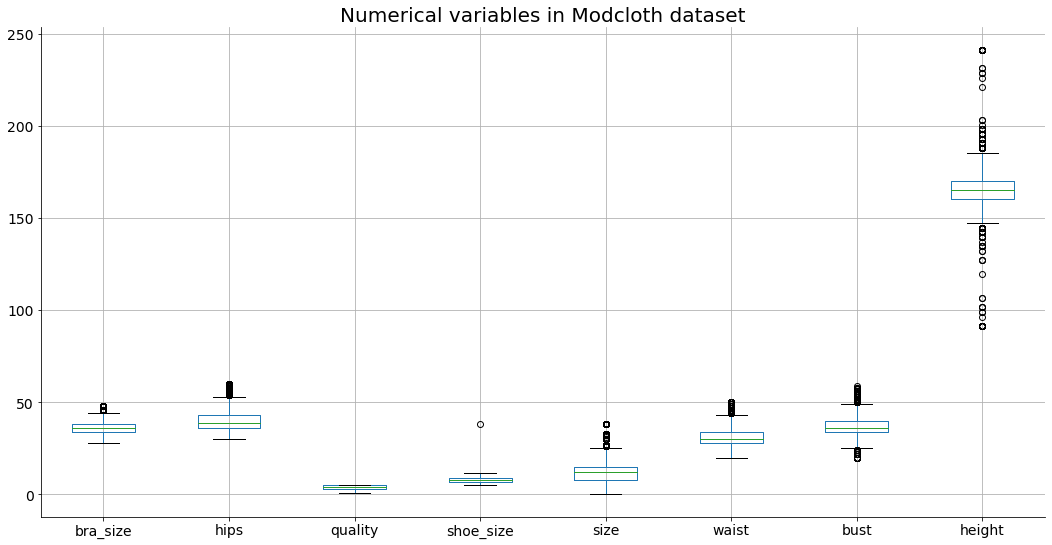

In [0]:
num_cols = ['bra_size','hips','quality','shoe_size','size','waist', 'bust', 'height', ]
plt.figure(figsize=(18,9))
modcloth_df[num_cols].boxplot()
plt.title("Numerical variables in Modcloth dataset", fontsize=20)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


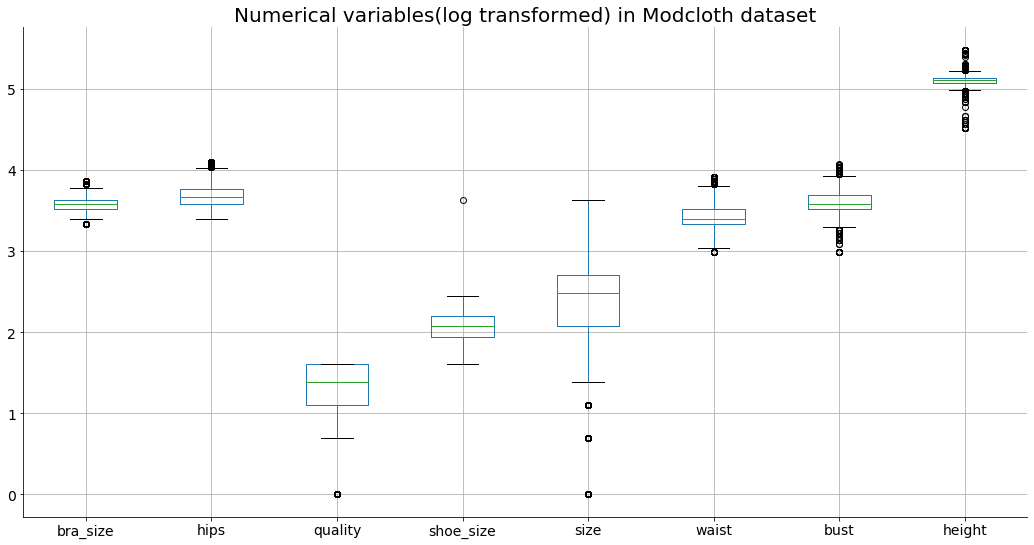

In [0]:
num_cols = ['bra_size','hips','quality','shoe_size','size','waist', 'bust', 'height', ]
plt.figure(figsize=(18,9))
np.log(modcloth_df[num_cols]).boxplot()
plt.title("Numerical variables(log transformed) in Modcloth dataset", fontsize=20)
plt.show()

As we can see there are a couple of variables with values that lies in the outlier range (by rule of thumb, although some deep analysis can be done if these anomalies can be explained and there is evidence to explain them) here i am presuming them to be outliers and removing the values beyond [<(Q1- 1.5*IQR), >Q3+1.5*IQR)]
- bra_size, hips, shoe_size, waist, bust, height


@Note :- Implement other methods if time permits

In [0]:
Q1 = modcloth_df.quantile(0.25)
Q3 = modcloth_df.quantile(0.75)
Q1.drop(["item_id","user_id"], inplace =True)
Q3.drop(["item_id","user_id"], inplace = True)
IQR = Q3 - Q1

In [0]:
modcloth_df = modcloth_df[~((modcloth_df < (Q1 - 1.5 * IQR)) |(modcloth_df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [0]:
modcloth_df.reset_index(drop=True, inplace=True)

# Handling Missing Values

In [0]:
# Checking amount of missing values
missing_data = pd.DataFrame({'perc_missing': (modcloth_df.isnull().sum()/modcloth_df.shape[0])*100})
missing_data.sort_values("perc_missing", ascending=False, inplace = True)
missing_data

,perc_missing
waist,96.371036
bust,85.001403
shoe_width,77.200393
shoe_size,65.216110
hips,31.618019
review_text,8.005894
review_summary,8.005894
cup_size,7.325288
bra_size,6.994106
height,1.211058


In [0]:
# The first 4 columns namely waist, bust, shoe_width and shoe_size have high number of mising data
# and hence should be dropped. shoe_size can be indicators for product to be a shoe
# otherwise they should be dropped as well


# Checking of product is a shoe 
shoe_review_df = modcloth_df[np.logical_and(pd.notnull(modcloth_df["review_text"]), pd.notnull(modcloth_df["shoe_size"]))][["user_name","shoe_size","review_text"]]

In [0]:
shoe_review_df.shape

(22958, 3)

In [0]:
# %age review containing shoe mentions
np.sum([True if len(re.findall(r"shoes|shoe",x))> 0 else False for x in shoe_review_df.review_text])/shoe_review_df.shape[0]

0.003745970903388797

In [0]:
 # There are 585 users with differing shoe_sizes (since time information is not present,
 # also the person for which the product is bought for is not known) it is difficult
 # to call this misrepresentation as an error
np.sum(shoe_review_df.groupby('user_name')['shoe_size'].unique().apply(lambda x: len(x)) > 1)

585

In [0]:
# There are roughly 700 new additions to the above logic, which means that for the same
# user the shoe_size is reported but is not reproted somewhere else in the data.
np.sum(modcloth_df.groupby('user_name')['shoe_size'].unique().apply(lambda x: len(x)) > 1)

1201

Allthough the above methodology above is heuristical but it gives a fair sense that presence of shoe sizes can't indicate that shoes were bought hence all the 4 columns should be removed. (bust was also found to be highly correlated to waist size,when i used the missingno heatmap without droppin the 4 columns)

There are other reasons to be aggressive at dropping information around shoe sizes check the correlation graph below between height and shoe_sizes

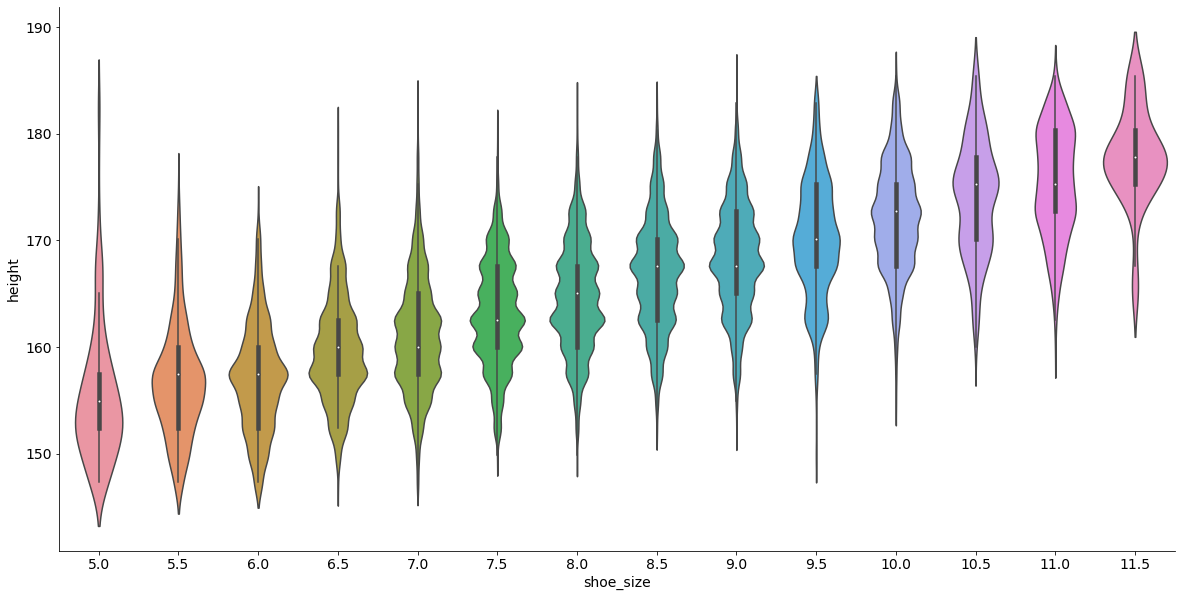

In [0]:
fig = plt.gcf()
fig.set_size_inches(20,10)
__ = sns.violinplot(x='shoe_size', y='height',data=modcloth_df)

In [0]:
modcloth_df.drop(["waist", "bust", "shoe_width", "shoe_size"], axis= 1, inplace=True)

Using the missing no package analye if the missing values follows a pattern when analyzed wrt another column

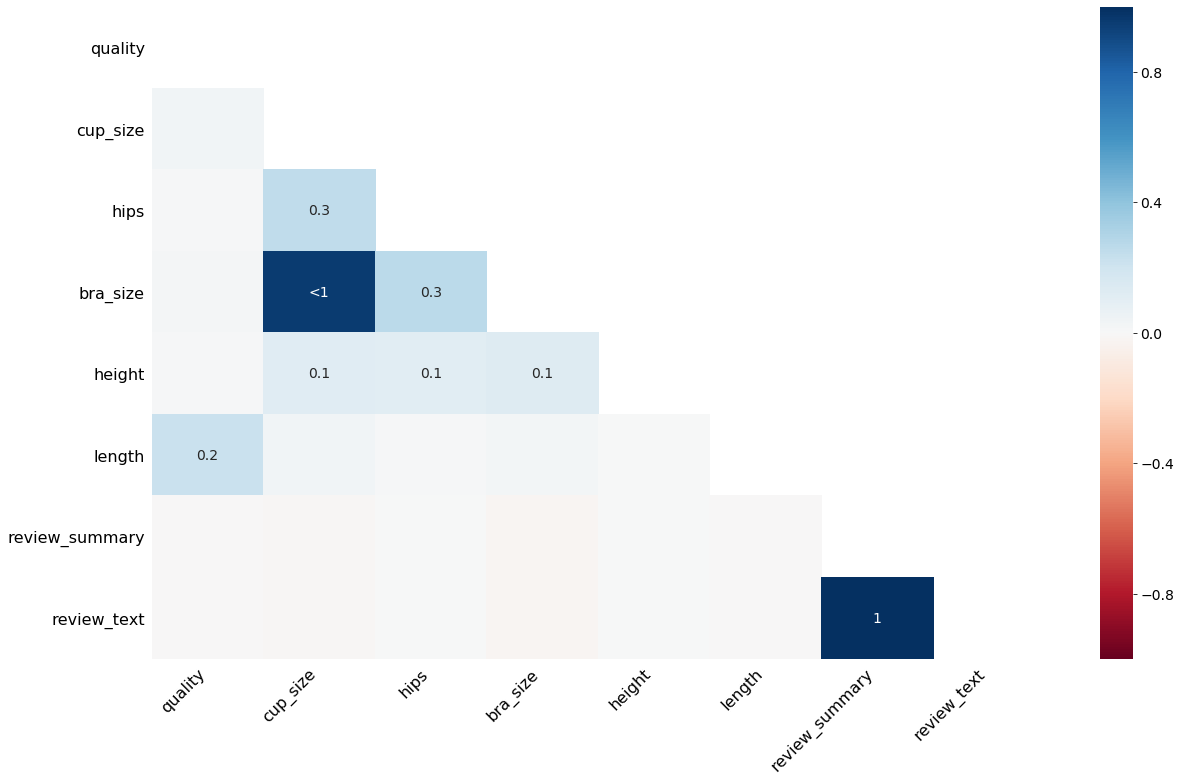

In [0]:
# missing values in different columns as a heatmap
msno.heatmap(modcloth_df)  

Some observations are :-
- Correlation of cupsize and brasize
  - Impute using mode for different category of cupsize and brasize
  - where both cupsize and brasize are nan use column mode
- review_summary and review_text are 1-to-1 match , their missing values can 
 be imputed by replacing with "Unknown"
- height, quality and length can be imputed by measures of central tendency
- mising value in hips doesn't show high correlation to any of the other columns
and hence we will categorize the column based on its distribution(kde plot)

### Handling cupsize and brasize

In [0]:
bra_size_to_cup_size = {x:y for x,y in modcloth_df.groupby("bra_size")["cup_size"].agg(pd.Series.mode).reset_index().values}
cup_size_to_bra_size = {x:y for x,y in modcloth_df.groupby("cup_size")["bra_size"].median().reset_index().values}

bra_size_med = modcloth_df.bra_size.median() 
cup_size_mod = bra_size_to_cup_size[bra_size_med] # not matching with cup size mode

In [0]:
imputed_value = []
for x,y in zip(modcloth_df["bra_size"],modcloth_df["cup_size"]):
  if pd.isnull(x) and pd.isnull(y):
    imputed_value.append([bra_size_med, cup_size_mod])
  elif pd.isnull(x) and pd.notnull(y):
    imputed_value.append([cup_size_to_bra_size[y], y])
  elif pd.notnull(x) and pd.isnull(y):
    imputed_value.append([x, bra_size_to_cup_size[x]])
  else:
    imputed_value.append([x,y])

In [0]:
modcloth_df[["bra_size","cup_size"]] = imputed_value

Although i have done this imputation but if i had dataset from fixed genders i would have kept the NAs as unknowns because it doesn't make business sense to hard impute values for all the kind of users.

### Handling Review text and summary

In [0]:
modcloth_df.review_summary.fillna("Unknown", inplace=True)
modcloth_df.review_text.fillna("Unknown", inplace=True)

### Handling height, quality and length data

In [0]:
from sklearn.preprocessing import Imputer
median_imputer = Imputer(missing_values='NaN', strategy='median', axis=0)
modcloth_df[['height','quality']] = median_imputer.fit_transform(modcloth_df[['height','quality']])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
modcloth_df["length"] = modcloth_df.length.fillna(modcloth_df['length'].value_counts().index[0])

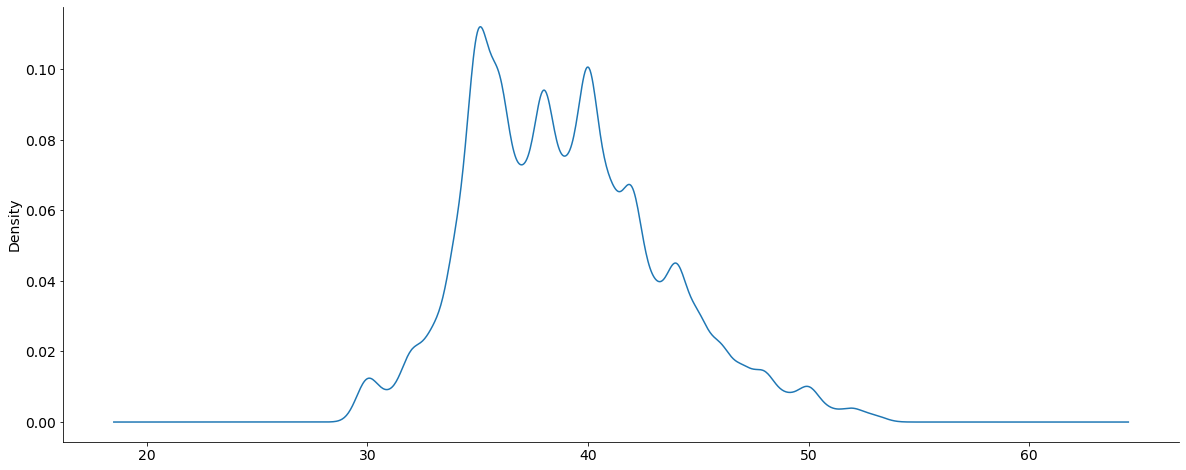

In [0]:
modcloth_df.hips.plot.kde()

In [0]:
modcloth_df.hips.fillna(-1.0, inplace = True)
bins = [-2,0,31,37,40,44,75]
labels = ['Unknown','XS','S','M', 'L','XL']
modcloth_df.hips = pd.cut(modcloth_df.hips, bins, labels=labels)

It is also observed that review_summary text is randomly truncated and hence is not that useful as compared to review_text column.


In [0]:
modcloth_df.drop('review_summary', axis=1, inplace = True)

In [0]:
name_id_df = modcloth_df.groupby("user_name")['user_id'].apply(lambda x: len(np.unique(x))).reset_index()
id_name_df = modcloth_df.groupby("user_id")['user_name'].apply(lambda x: len(np.unique(x))).reset_index()


On analysis it looks like that the user_name needs to be normalized by lowering them and also user_id is not he the correct column to keep as one user_name has many user_id but one user_id has just one type of user_name on normalization

In [0]:
modcloth_df.drop('user_id', axis=1, inplace = True)
modcloth_df["user_name"] = modcloth_df.user_name.apply(lambda x: x.lower())

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from sklearn.model_selection import train_test_split

TensorFlow 2.x selected.


In [0]:
tf.__version__

'2.1.0-rc1'

# Building a Deep learning model inspired by architecture in the given paper,
# https://arxiv.org/pdf/1907.09844.pdf (Fig 1)


In [0]:
# Split into train and validation dataset, i am not showing any performance on 
# test dataset for now,
train, val = train_test_split(modcloth_df, test_size=0.2)

In [0]:
user_categorical_features = ["user_name","hips","cup_size"]
user_numerical_features = ["height","bra_size"]
item_categorical_features = ["item_id", "category", "length"]
item_numerical_features = ["size","quality"]

In [0]:
# Scaling the numerical features
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler().fit(train[["height","bra_size","size","quality"]])

In [0]:
train[["height","bra_size","size","quality"]] = scaler.transform(train[["height","bra_size","size","quality"]])
val[["height","bra_size","size","quality"]] = scaler.transform(val[["height","bra_size","size","quality"]])


In [0]:
for col in user_categorical_features + item_categorical_features:
  modcloth_df[col] = modcloth_df[col].astype(str) 

In [0]:
# 1) Create feature columns for ingestion into NN

# Numeric Columns
numeric_users = {
    col : feature_column.numeric_column(col) \
          for col in user_numerical_features
}
numeric_items = {
    col : feature_column.numeric_column(col) \
          for col in item_numerical_features
}

# Categorical Columns
# Now categorical columns can be encoded into one-hot vectors and fed into NN
# But the paper has used embedding and hence we can use the same (generally used for
# a categroical feature with lots of categories, but let us see)

hips = feature_column.categorical_column_with_vocabulary_list(
      'hips', modcloth_df.hips.unique().tolist())
cup_size = feature_column.categorical_column_with_vocabulary_list(
      'cup_size', modcloth_df.cup_size.unique().tolist())
user_name = feature_column.categorical_column_with_vocabulary_list(
      'user_name', modcloth_df.user_name.unique().tolist())



item_id = feature_column.categorical_column_with_vocabulary_list(
      'item_id', modcloth_df.item_id.unique().tolist())
category = feature_column.categorical_column_with_vocabulary_list(
      'category', modcloth_df.category.unique().tolist())
length = feature_column.categorical_column_with_vocabulary_list(
      'length', modcloth_df.length.unique().tolist())

# There are 6 dimension hyperparameters to be given here which is a lot,
# hence for now i am giving these values, later we will see if we can
# somehow guide the decision via cross-val
hips_embedding = feature_column.embedding_column(hips, dimension=5)
cup_size_embedding = feature_column.embedding_column(cup_size, dimension=5)
user_name_embedding = feature_column.embedding_column(user_name, dimension=50)
item_id_embedding = feature_column.embedding_column(item_id, dimension=50)
category_embedding = feature_column.embedding_column(category, dimension=5)
length_embedding = feature_column.embedding_column(length, dimension=5)

cat_users = {
    'hips' : hips_embedding,
    'cup_size' : cup_size_embedding,
    'user_name': user_name_embedding
}

cat_items = {
    'item_id' : item_id_embedding,
    'category' : category_embedding,
    'length': length_embedding
}

input_user = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') \
          for colname in numeric_users.keys()
}
input_user.update({
    colname : tf.keras.layers.Input(name=colname, shape=(),  dtype='string') \
          for colname in cat_users.keys()
})

input_items = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype = 'float32') \
          for colname in numeric_items.keys()
}

input_items.update({
    colname : tf.keras.layers.Input(name=colname, shape=(),  dtype='string') \
          for colname in cat_items.keys()
})


In [0]:
# Create a feature layer
feature_layer_users = keras.layers.DenseFeatures(numeric_users.values())(input_user)
feature_layer_items = keras.layers.DenseFeatures(numeric_items.values())(input_items)

In [0]:
CLASS_LABELS =  np.array(["fit","small","large"])

In [0]:
# 2) Create a input pipeline using tf.data
# A utility method to create a tf.data dataset from a Pandas Dataframe
import copy
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('fit')
  labels = labels.apply(lambda x:x == CLASS_LABELS)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  #prefetching was giving some trouble on google colab,
  #there might be some issue with some gdfs, hence not here
  return ds

The class defined below is basically the trapezium blocks show in Fig 1 of the paper, this is how i am thinking that skip connections would have been formed (there are no details or implementation available to reinforce my believe).

In [0]:
class SkipCon(keras.layers.Layer):
  def __init__(self, size, reduce = True, deep = 3, skip_when=0, activation="relu", **kwargs):
    """
    @Params
    size = size of dense layer
    deep = the depth of network in one SkipCon block call
    skip_when =  if a skip connection is required, pass 1
    activation = by default using relu, in the paper authors have used tanh(no reasons again)
    """    
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation) # used to combine
    # skip connections and cascaded dense layers
    self.main_layers =[]
    self.skip_when = skip_when #to be used in call as a control
    if reduce:
      for _ in range(deep):
        self.main_layers.extend([
          keras.layers.Dense(size, activation=activation, 
                              use_bias=True),
          keras.layers.BatchNormalization()])

        # Reduce the input size by two each time, if the
        # network is to be designed deeper and narrow
        size = size/2
    else:
      for _ in range(deep):
        self.main_layers.extend([
        keras.layers.Dense(size, activation=activation, 
                            use_bias=True),
        keras.layers.BatchNormalization()])
        
    self.skip_layers = []
    if skip_when > 0:
      if reduce:
        size = size*2 # since the size of skipped connection  
                      # should match with cascaded dense
      self.skip_layers = [
          keras.layers.Dense(size, activation=activation, 
                          use_bias=True),
          keras.layers.BatchNormalization()]

  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    if not self.skip_when:
      return self.activation(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [0]:
batch_size = 512 # paper they have taken 2048 batch size, but no clear explanation
# tanh activation is used, but i am using relu
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

In [0]:
user_layer = keras.layers.Dense(256, activation='relu', use_bias = True)(feature_layer_users)
# Add a Skip Connection
user_layer = SkipCon(size = 256, deep = 2, reduce = False, skip_when=1, activation="relu")(user_layer)
user_layer = keras.layers.Dropout(0.5)(user_layer) # Way to handle overfitting
user_layer = SkipCon(size = 256, deep = 2, reduce = True, skip_when=1, activation="relu")(user_layer)
user_layer = keras.layers.Dropout(0.5)(user_layer)
user_layer = SkipCon(size = 64, deep = 2, reduce = True, skip_when=0, activation="relu")(user_layer)


item_layer = keras.layers.Dense(256, activation='relu', use_bias = True)(feature_layer_items)
# Add a Skip Connection
item_layer = SkipCon(size = 256, deep = 2, reduce = False, skip_when=1, activation="relu")(item_layer)
item_layer = keras.layers.Dropout(0.5)(item_layer) # Way to handle overfitting
item_layer = SkipCon(size = 256, deep = 2, reduce = True, skip_when=1, activation="relu")(item_layer)
item_layer = keras.layers.Dropout(0.5)(item_layer)
item_layer = SkipCon(size = 64, deep = 2, reduce = True, skip_when=0, activation="relu")(item_layer)


# combine the output of the two branches
combined = tf.concat([user_layer, item_layer], axis =-1)

# The combined input should go through another set of skip connection non-linearity as per the paper
both_layer = SkipCon(size = 128, deep = 2, reduce = False, skip_when=1, activation="relu")(combined)
both_layer = keras.layers.Dropout(0.5)(both_layer)
both_layer = SkipCon(size = 64, deep = 2, reduce = False, skip_when=1, activation="relu")(combined)
both_layer = keras.layers.Dropout(0.5)(both_layer)
both_layer = SkipCon(size = 16, deep = 2, reduce = False, skip_when=0, activation="relu")(both_layer)

z = keras.layers.Dense(3, activation="softmax")(both_layer)

model = keras.Model(inputs=[input_user, input_items], outputs=z)



In [0]:
# Another control put in place to handle overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.01)
model.compile(optimizer= optimizer,
              loss='categorical_crossentropy',
              metrics=METRICS,
              callbacks = [early_stopping])


In [0]:
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=15)

Epoch 1/15
112/112 [==============================] - 22s 197ms/step - loss: 0.8588 - tp: 38627.0000 - fp: 16950.0000 - tn: 97066.0000 - fn: 18381.0000 - accuracy: 0.7934 - precision: 0.6950 - recall: 0.6776 - auc: 0.7791 - val_loss: 0.0000e+00 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/15
112/112 [==============================] - 12s 110ms/step - loss: 0.8102 - tp: 39783.0000 - fp: 16826.0000 - tn: 97190.0000 - fn: 17225.0000 - accuracy: 0.8009 - precision: 0.7028 - recall: 0.6978 - auc: 0.7982 - val_loss: 0.8162 - val_tp: 9993.0000 - val_fp: 4259.0000 - val_tn: 24245.0000 - val_fn: 4259.0000 - val_accuracy: 0.8008 - val_precision: 0.7012 - val_recall: 0.7012 - val_auc: 0.7962
Epoch 3/15
112/112 [==============================] - 12s 109ms/step - loss: 0.8070 - tp: 39690.0000 - fp: 16715.0000 - tn: 97301.0000 - fn: 17318.0000 - accurac

# Vizualize the training layers

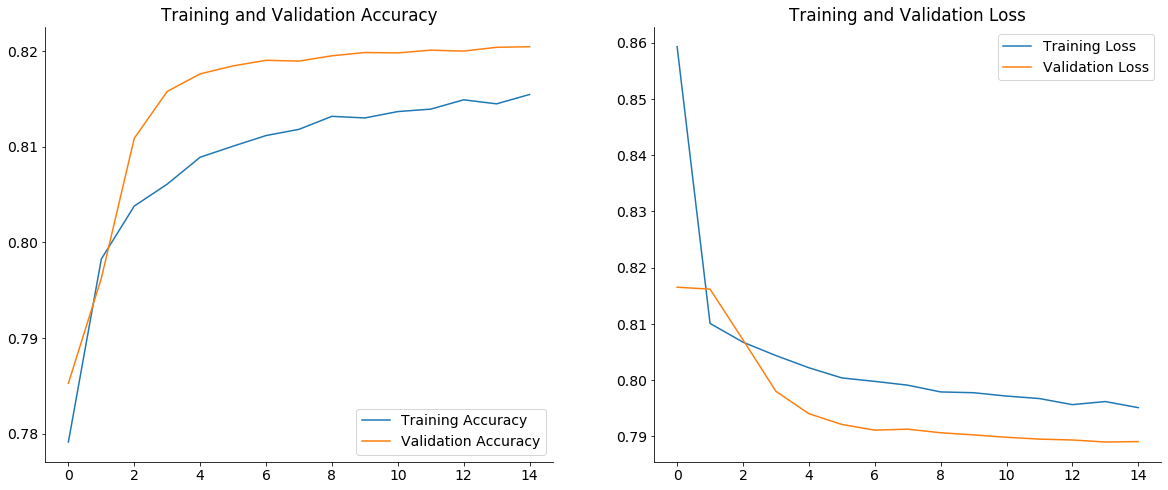

In [0]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training Accuracy')
plt.plot(epochs_range, val_auc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
# Let us see how we can handle the review_text (since this has been ignored in the paper)
# Proposing a text classification based model which uses review_text to predict the "fit"
#Since here we are only using review_text as a column we will be removing all the null or "Unknown" values
modcloth_df_text = modcloth_df[~modcloth_df.review_text.isin(["Unknown"])][["review_text","fit"]]

# Experimenting with text classifcation algorithms,
- Transfer Learning based (Transformers) :- Bert, ULMFit, GPT

There can be a lot other forms of doing text classification (mainly better feature engineering(topic models, tf-idf, syntax based), but then it will be altogether a new problem.

In [0]:
# Split into train and validation dataset
train_text, val_text = train_test_split(modcloth_df_text, test_size=0.2)

In [0]:
# 2) Create a input pipeline using tf.data
# A utility method to create a tf.data dataset from a Pandas Dataframe
import copy
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('fit')
  labels = labels.apply(lambda x:x == CLASS_LABELS)
  ds = tf.data.Dataset.from_tensor_slices((dataframe.review_text.values, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  #prefetching was giving some trouble on google colab,
  #there might be some issue with some gdfs, hence not here
  return ds
train_ds_text = df_to_dataset(train_text, batch_size = 32)
val_ds_text = df_to_dataset(val_text, batch_size = 32)

In [0]:
import tensorflow_hub as hub

In [0]:
# # Pre-trained Embedding
# model_embedding = keras.Sequential([
#     hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1",
#                    dtype=tf.string, input_shape=[], output_shape=[128]),
#     keras.layers.Dense(128, activation="relu"),
#     keras.layers.Dense(64, activation="relu"),
#     keras.layers.Dense(64, activation="relu"),
#     keras.layers.Dense(32, activation="relu"),
#     keras.layers.Dense(10, activation="relu"),
#     keras.layers.Dense(3, activation="sigmoid")
# ])

model_embedding = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                   dtype=tf.string, input_shape=[], output_shape=[512]),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(3, activation="sigmoid")
])


In [0]:
# Another control put in place to handle overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.01)
model_embedding.compile(optimizer= optimizer,
              loss='categorical_crossentropy',
              metrics=METRICS,
              callbacks = [early_stopping])

In [0]:
model_embedding.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense_27 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_28 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_29 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_32 (Dense)             (None, 10)                3

In [0]:
history = model_embedding.fit(train_ds_text,
          validation_data=val_ds_text,
          epochs=15)

Epoch 1/15
1639/1639 [==============================] - 49s 30ms/step - loss: 0.6506 - tp: 39419.0000 - fp: 15164.0000 - tn: 89724.0000 - fn: 13025.0000 - accuracy: 0.8208 - precision: 0.7222 - recall: 0.7516 - auc: 0.8870 - val_loss: 0.0000e+00 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/15
1639/1639 [==============================] - 45s 27ms/step - loss: 0.6454 - tp: 39055.0000 - fp: 14259.0000 - tn: 90629.0000 - fn: 13389.0000 - accuracy: 0.8243 - precision: 0.7325 - recall: 0.7447 - auc: 0.8888 - val_loss: 0.6476 - val_tp: 9719.0000 - val_fp: 3581.0000 - val_tn: 22641.0000 - val_fn: 3392.0000 - val_accuracy: 0.8227 - val_precision: 0.7308 - val_recall: 0.7413 - val_auc: 0.8880
Epoch 3/15
1639/1639 [==============================] - 44s 27ms/step - loss: 0.6430 - tp: 38872.0000 - fp: 13847.0000 - tn: 91041.0000 - fn: 13572.0000 - accu

In [0]:
from datetime import date,datetime
today = datetime.now().strftime("%d%m%Y_%H%M%S")
model_dir = os.path.join(BASE_MODEL_PATH,"Text",today+'_text_model.h5')

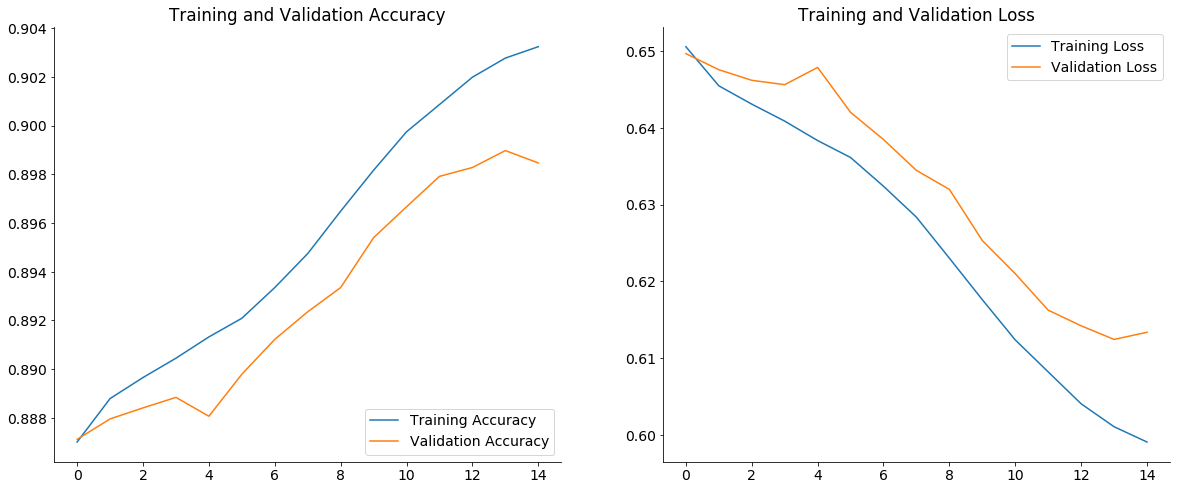

In [0]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training Accuracy')
plt.plot(epochs_range, val_auc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
# Save the model
model_embedding.save(model_dir)

# Recreate the exact same model purely from the file
# text_model = tf.keras.models.load_model(model_dir, custom_objects={'KerasLayer':hub.KerasLayer})